In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import matplotlib

In [2]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
def calc_emi(borrow, irate, months):
    emi = borrow*irate*((1+irate)**months)
    emi = emi/((1+irate)**months - 1)
    return emi

def amort_schedule(borrow, irate, months):
    emi = calc_emi(borrow, irate, months)
    amort_schedule = []
    remain_notional = borrow
    for m in range(months):
        payment = emi
        curr_notional = remain_notional
        int_paid = curr_notional*irate
        principal_paid = emi - int_paid
        remain_notional = curr_notional - principal_paid
        pdict = {'month': m,
                 'payment': payment,
                 'curr_notional': curr_notional,
                 'int_paid': int_paid,
                 'principal_paid': principal_paid,
                 'remain_notional': remain_notional}
        amort_schedule.append(pdict)
    amort_schedule_df = pd.DataFrame(amort_schedule)
    amort_schedule_df['cum_int_paid'] = np.cumsum(amort_schedule_df['int_paid'])
    amort_schedule_df['cum_principal_paid'] = np.cumsum(amort_schedule_df['principal_paid'])
    amort_schedule_df = amort_schedule_df.round(2)
    return amort_schedule_df


def home_own_expense(borrow, irate, months, annual_tax=9000, 
                     annual_maintenance=9000, monthly_insurance=200, HOA=0):
    hown_expense = amort_schedule(borrow, irate, months)
    hown_expense['cum_tax'] = np.cumsum(np.full_like(hown_expense['payment'].values, 
                                                      1.)*annual_tax/12)
    hown_expense['cum_insurance'] = np.cumsum(np.full_like(hown_expense['payment'].values, 
                                                      1.)*monthly_insurance)
    hown_expense['cum_maintenance'] = np.cumsum(np.full_like(hown_expense['payment'].values, 
                                                      1.)*annual_maintenance/12)
    hown_expense['cum_HOA'] = np.cumsum(np.full_like(hown_expense['payment'].values, 
                                                      1.)*HOA)
    sumcols = ['cum_int_paid', 'cum_principal_paid', 'cum_tax', 
               'cum_insurance', 'cum_maintenance', 'cum_HOA']
    hown_expense['total_expense'] = np.sum(hown_expense[sumcols], axis=1)
    hown_expense = hown_expense.round(2)
    return hown_expense

def sell_profit(hown_expense, sell_price, buy_overhead, downpay_amount, 
                agent_fee=0.06, finish_cost=2e4, monthly_rent=3e3):
    agent_pay = agent_fee*sell_price
    sell_overhead = agent_pay + finish_cost
    net_pay = sell_price - sell_overhead - buy_overhead - downpay_amount
    
    sell_cashin = []
    sell_cashin_net_inttaxins = []
    sell_cashin_net_inttaxins_maint = []
    
    cumcols = ['cum_principal_paid','cum_int_paid', 'cum_tax', 'cum_insurance', 'cum_HOA'] 
    for ri, rr in hown_expense.iterrows():
        sell_cashin.append(net_pay - rr['remain_notional'])
        sell_cashin_net_inttaxins.append(sell_cashin[-1] - rr[cumcols].sum())
        sell_cashin_net_inttaxins_maint.append(sell_cashin_net_inttaxins[-1] - rr['cum_maintenance'])
    
    hown_expense['sell_cashin'] = sell_cashin
    hown_expense['sell_cashin_net_inttaxins'] = sell_cashin_net_inttaxins
    hown_expense['sell_cashin_net_inttaxins_maint'] = sell_cashin_net_inttaxins_maint
    hown_expense['cum_rent'] = -np.cumsum(np.full(hown_expense.shape[0], 1., dtype=np.float32)*monthly_rent)
    return hown_expense
    

In [38]:
buy_price = 475e3
downpay = 0.2
downpay_amount = downpay*buy_price
borrow_amount = buy_price*(1 - downpay)
irate = 3.5/100/12 # monthly
months = 30*12
rent  = 3000


# buying overheads 
buy_closing_cost = 15000
finish_cost = 25000
buy_overhead = buy_closing_cost + finish_cost
    
# selling overheads 
sell_price = 525e3
# agent_pay = 0.06*sell_price
# sell_overhead = agent_pay + finish_cost

In [39]:
hown_expense = home_own_expense(borrow_amount, irate, months, annual_tax=6000,
                               annual_maintenance=0, monthly_insurance=250, HOA=500)
hown_buy_sell = sell_profit(hown_expense, sell_price, buy_overhead, 
                            downpay_amount, agent_fee=0.06, finish_cost=1e4, monthly_rent=rent)

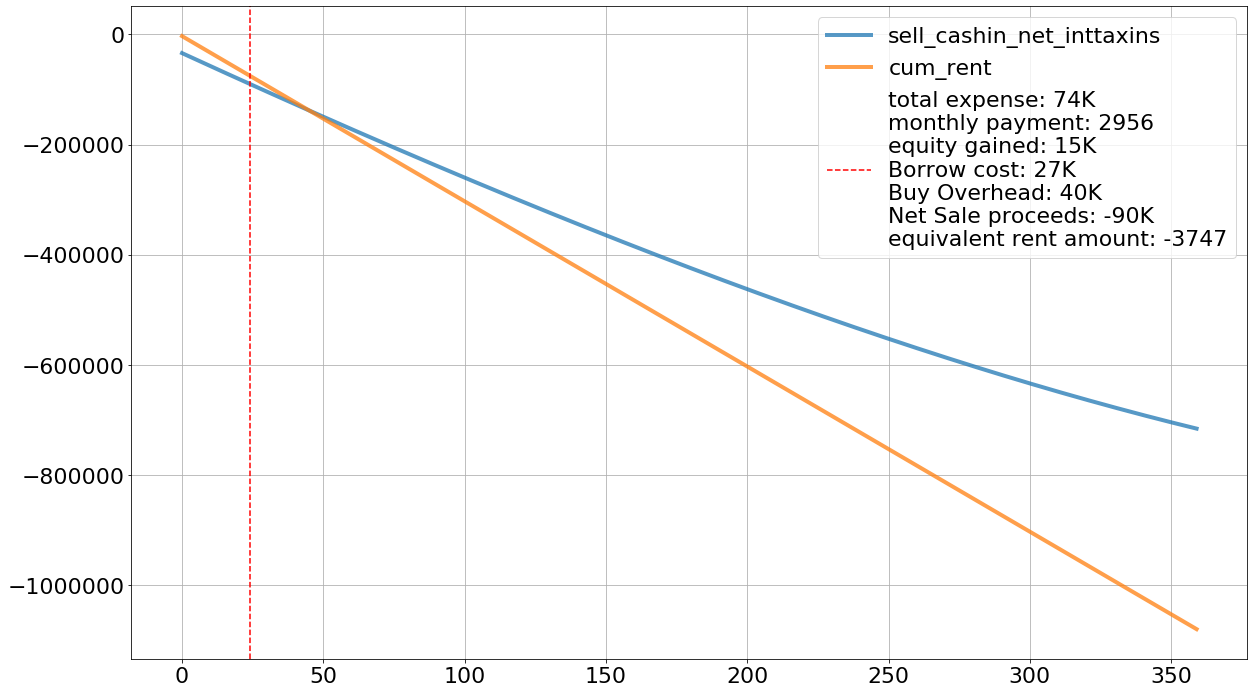

In [40]:
vline = 12*2
vline_idx = np.where(hown_buy_sell['month']==vline)[0][0]
vline_value = hown_buy_sell.iloc[vline_idx]
totexpense = vline_value['total_expense']/1e3
equitygained = vline_value['cum_principal_paid']/1e3
borrowcost = vline_value['cum_int_paid']/1e3
net_proceeds_sale = vline_value['sell_cashin_net_inttaxins']/1e3
monthly_payment = hown_buy_sell.iloc[0]['total_expense']
vline_label = f'total expense: {totexpense:.0f}K\n'
vline_label += f'monthly payment: {monthly_payment:.0f}\n'
vline_label += f'equity gained: {equitygained:.0f}K\n'
vline_label += f'Borrow cost: {borrowcost:.0f}K\n'
vline_label += f'Buy Overhead: {buy_overhead/1e3:.0f}K\n'
vline_label += f'Net Sale proceeds: {net_proceeds_sale:.0f}K\n'
vline_label += f'equivalent rent amount: {net_proceeds_sale/vline*1e3:.0f}'

# toplot = ['cum_int_paid', 'cum_principal_paid', 'total_expense']
toplot = ['sell_cashin_net_inttaxins', 'cum_rent']
df_slice = hown_buy_sell[toplot]
df_slice.plot(alpha=0.75, linewidth=4, label=True, figsize=(20,12), grid=True)
plt.axvline(vline, color='red', linestyle='--', label=vline_label)
plt.legend()

In [32]:
hown_buy_sell.tail()[['cum_principal_paid','cum_int_paid', 'cum_tax', 'cum_insurance', 'cum_HOA', 'cum_rent']]

,cum_principal_paid,cum_int_paid,cum_tax,cum_insurance,cum_HOA,cum_rent
355,412510.74,258900.88,178000.0,89000.0,178000.0,-1068000.0
356,414374.88,258922.72,178500.0,89250.0,178500.0,-1071000.0
357,416244.46,258939.13,179000.0,89500.0,179000.0,-1074000.0
358,418119.50,258950.08,179500.0,89750.0,179500.0,-1077000.0
359,420000.00,258955.57,180000.0,90000.0,180000.0,-1080000.0


In [36]:
hown_buy_sell.head()

,month,payment,curr_notional,int_paid,principal_paid,remain_notional,cum_int_paid,cum_principal_paid,cum_tax,cum_insurance,cum_maintenance,cum_HOA,total_expense,sell_cashin,sell_cashin_net_inttaxins,sell_cashin_net_inttaxins_maint,cum_rent
0,0,1885.99,420000.00,1225.00,660.99,419339.01,1225.00,660.99,500.0,250.0,0.0,500.0,3135.99,-55839.01,-58975.00,-58975.00,-3000.0
1,1,1885.99,419339.01,1223.07,662.92,418676.10,2448.07,1323.90,1000.0,500.0,0.0,1000.0,6271.97,-55176.10,-61448.07,-61448.07,-6000.0
2,2,1885.99,418676.10,1221.14,664.85,418011.25,3669.21,1988.75,1500.0,750.0,0.0,1500.0,9407.96,-54511.25,-63919.21,-63919.21,-9000.0
3,3,1885.99,418011.25,1219.20,666.79,417344.46,4888.41,2655.54,2000.0,1000.0,0.0,2000.0,12543.95,-53844.46,-66388.41,-66388.41,-12000.0
4,4,1885.99,417344.46,1217.25,668.73,416675.73,6105.66,3324.27,2500.0,1250.0,0.0,2500.0,15679.93,-53175.73,-68855.66,-68855.66,-15000.0


In [ ]:
3000